#The Efficient Frontier: Markowitz Portfolio optimization in Python
By Dr. Thomas Starke, David Edwards, Dr. Thomas Wiecki

Notebook released under the Creative Commons Attribution 4.0 License.

---

## Introduction
In this blog post you will learn about the basic idea behind Markowitz portfolio optimization and how to do it in Python. We will then show a simple backtest that rebalances its portfolio in a Markowitz-optimal way. We hope you enjoy it and find it enlightening.

We will start by using random data and save actual stock data for later. This will hopefully help you get a sense of how to use modelling and simulation to improve your understanding of the theoretical concepts. Don‘t forget that the skill of an algo-trader is to put mathematical models into code, and this example is great practice.

Let's start with importing a few modules which we need later, and producing a series of normally distributed returns. `cvxopt` is a convex solver which we will use for the optimization of the portfolio.

## Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

Assume that we have 4 assets, each with a return series of length 1000. We can use `numpy.random.randn` to sample returns from a normal distribution.

In [2]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

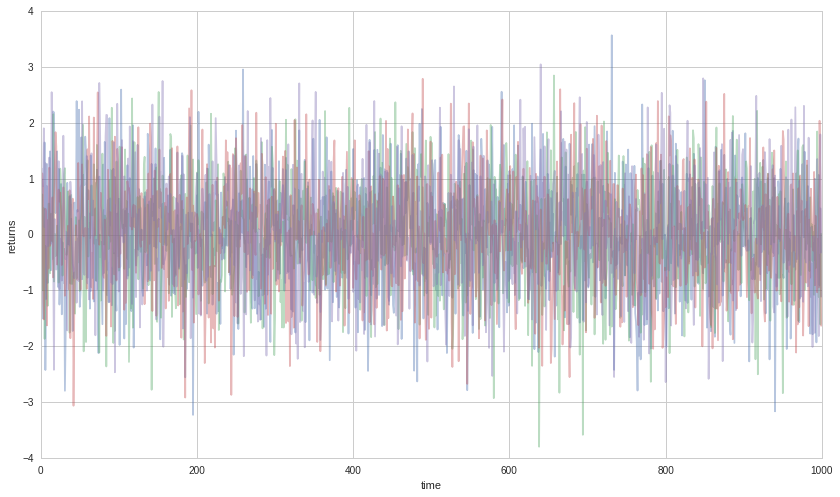

In [3]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns');

These return series can be used to create a wide range of portfolios. We will produce random weight vectors and plot those portfolios. As we want all our capital to be invested, the weights will have to sum to one.

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


Next, let's evaluate how these random portfolios would perform by calculating the mean returns and the volatility (here we are using standard deviation). You can see that there is
a filter so that we only plot portfolios with a standard deviation of < 2 for better illustration.

In [5]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
        
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

We calculate the return using

$$ R = p^T w $$

where $R$ is the expected return, $p^T$ is the transpose of the vector for the mean
returns for each time series and w is the weight vector of the portfolio. $p$ is a $N \times 1$
column vector, so $p^T$ turns is a $1 \times N$ row vector which can be multiplied with the
$N \times 1$ weight (column) vector w to give a scalar result. This is equivalent to the dot
product used in the code. Keep in mind that `Python` has a reversed definition of
rows and columns and the accurate `NumPy` version of the previous equation would
be `R = w * p.T`

Next, we calculate the standard deviation

$$\sigma = \sqrt{w^T C w}$$

where $C$ is the $N \times N$ covariance matrix of the returns. Please
note that if we simply calculated the simple standard deviation with the appropriate weighting using `std(array(ret_vec).T*w)` we would get a slightly different
’bullet’. This is because the simple standard deviation calculation would not take
covariances into account. In the covariance matrix, the values on the diagonal
represent the simple variances of each asset, while the off-diagonal entries are the variances between the assets. By using ordinary `std()` we effectively only regard the
diagonal and miss the rest. A small but significant difference.

Lets generate the mean returns and volatility for 500 random portfolios:

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

Upon plotting these you will observe that they form a characteristic parabolic
shape called the "Markowitz bullet" whose upper boundary is called the "efficient
frontier", where we have the lowest variance for a given expected return.

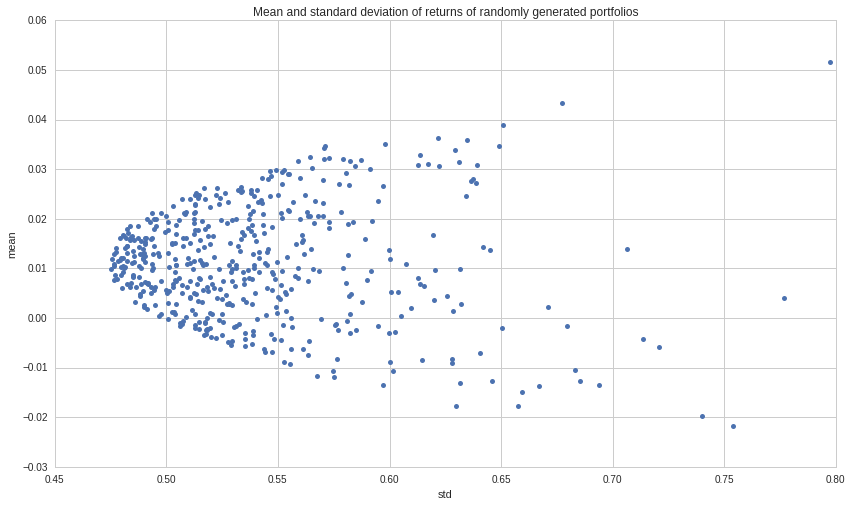

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios');

## Markowitz optimization and the Efficient Frontier

We can now calculate the efficient frontier Markowitz-style. This is done by minimizing

$$ w^T C w$$

for fixed expected portfolio return $R^T w$ while keeping the sum of all the
weights equal to 1:

$$ \sum_{i}{w_i} = 1 $$

Here we parametrically run through $R^T w = \mu$ and find the minimum variance
for different $\mu$‘s. This can be done with `scipy.optimise.minimize` but we have
to define quite a complex problem with bounds, constraints and a Lagrange multiplier. Conveniently, the `cvxopt` package, a convex solver, does all of that for us. We used one of their [examples]() with some modifications as shown below. For more information on using this package please have a look at the `cvxopt` example.

The `mus` vector produces a non-linear series of expected return values $\mu$, for each of which we will find a minimum-variance portfolio. We will see later that we don‘t need to calculate a lot of these, as they perfectly fit a parabola which can safely be extrapolated for higher values.

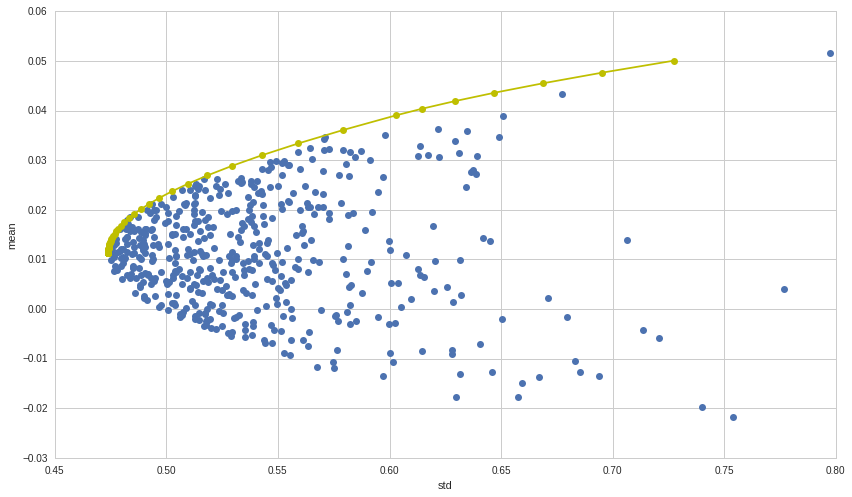

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o');

In yellow you can see the optimal portfolios for each of the desired returns (i.e. the `mus`). In addition, we get the weights for one optimal portfolio:

In [9]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


## Backtesting on real market data
This is all very interesting but not very applied. We next demonstrate how you can create a simple algorithm in [`zipline`](http://github.com/quantopian/zipline) -- the open-source backtester that powers [Quantopian](https://www.quantopian.com) -- to test this optimization on actual historical stock data.

First, lets load in some historical data using [Quantopian](https://www.quantopian.com)'s `get_pricing()`.

In [10]:
tickers = ['IBM', 'SBUX', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']
data = get_pricing(
    tickers,
    start_date='2005-01-01',
    end_date='2015-01-01'
)

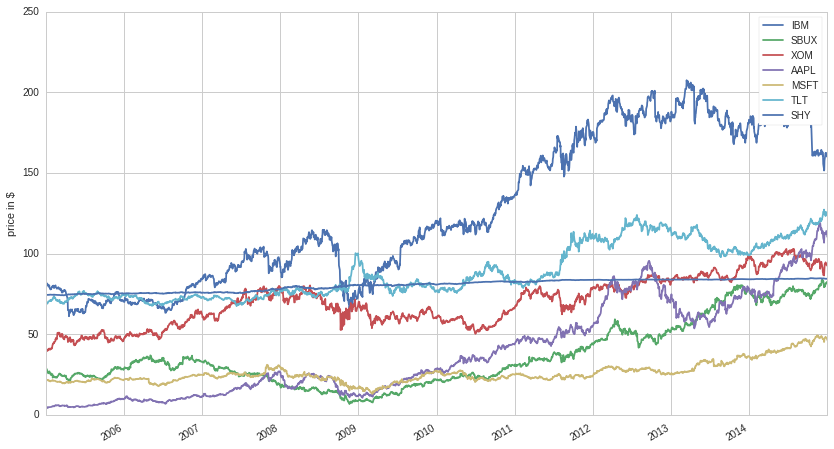

In [11]:
data.loc['price', :, :].plot()
plt.ylabel('price in $')
plt.legend(tickers);

Next, we'll create a `zipline` algorithm by defining two functions: `initialize()`, which is called once before the simulation starts, and `handle_data()`, which is called for every trading bar. We then instantiate the algorithm object.

If you are confused about the syntax of `zipline`, check out the [tutorial](http://www.zipline.io/beginner-tutorial.html).

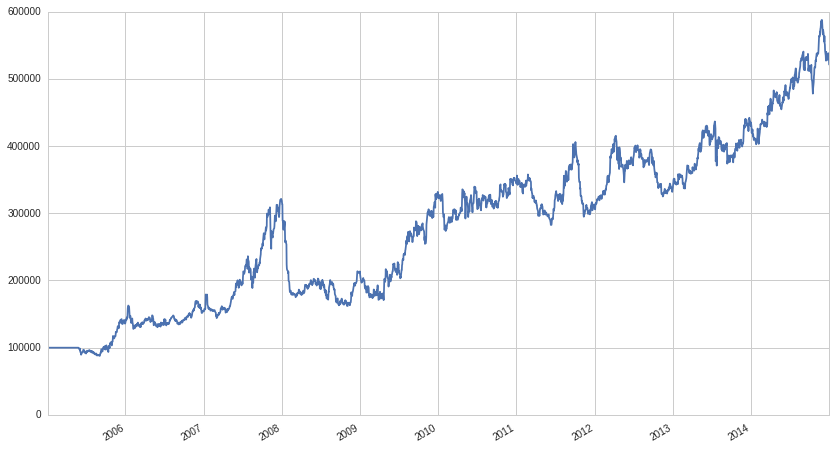

In [12]:
import zipline
from zipline.api import (
    set_slippage, 
    slippage,
    set_commission, 
    commission, 
    order_target_percent,
    symbols
)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    context.assets = symbols('IBM', 'SBUX', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY')
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = data.history(context.assets, 'price', 100, '1d').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data.swapaxes(2, 0, 1))
results.portfolio_value.plot();

As you can see, the performance here is quite good, even through the 2008 financial crisis. This is most likey due to our universe selection and shouldn't always be expected. Increasing the number of stocks in the universe might reduce the volatility as well. Please let us know in the comments section if you had any success with this strategy and how many stocks you used.

## Conclusions

In this blog, co-written by Quantopian friend [Dr. Thomas Starke](http://drtomstarke.com/), we wanted to provide an intuitive and gentle introduction to Markowitz portfolio optimization which still remains relevant today. By simulating various random portfolios we have seen that certain portfolios perform better than others. Convex optimization using `cvxopt` allowed us to then numerically determine the portfolios that live on the *efficient frontier*. The zipline backtest serves as an example but also shows compelling performance.

## Next steps

* Clone this notebook in the [Quantopian Research Platform](http://blog.quantopian.com/quantopian-research-your-backtesting-data-meets-ipython-notebook/) and run it on your own to see if you can enhance the performance. 
* You can also download just the notebook for use in your own environment [here]().
* In a future blog post we will outline the connections to Kelly optimization which also tells us the amount of leverage to use.
* We have added an optimization API which you can find [here](https://www.quantopian.com/posts/optimize-api-now-available-in-algorithms).

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*